In [1]:
import torch
from frames.representations import FrameUnembeddingRepresentation, Concept
import matplotlib.pyplot as plt
import cuml
import numpy as np
import seaborn as sns
from frames.utils.ml import run_umap
import pandas as pd

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

In [2]:
fur = FrameUnembeddingRepresentation.from_model_id(
    "meta-llama/Meta-Llama-3.1-8B-Instruct",
    device_map="cuda:0",
    torch_dtype=torch.bfloat16,
    quantization=4
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-30 15:42:18.047 | INFO     | frames.models.hf.base:__init__:88 - Loaded model: meta-llama/Meta-Llama-3.1-8B-Instruct
2025-07-30 15:42:18.048 | WARNING  | frames.models.hf.base:__init__:89 - memory cost: 5332 Mb


In [3]:
single_token_words = fur.data.get_dataframe(
    fur.model.tokenizer,
    min_lemmas_per_synset=1,
    max_token_count=1,
)["tokens"].list.get(0).unique().values.tolist()

tensor = fur.get_token_representations(single_token_words)

tensor.shape, tensor.device, tensor.dtype

(torch.Size([24538, 4096]), device(type='cuda', index=0), torch.bfloat16)

In [4]:
OPTIONS = {
    "min_lemmas_per_synset": 1,
    "max_token_count": 3,
}

df = fur.data.get_dataframe(fur.model.tokenizer, **OPTIONS)

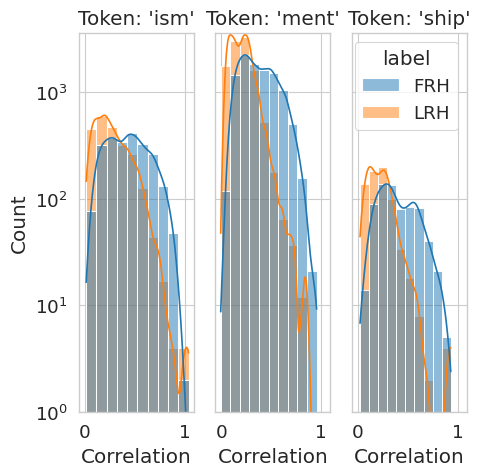

In [6]:
TOKENS = ["ism", "ment", "ship"]

fig, axes = plt.subplots(1, 3, figsize=(5, 5), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.3)

x = "Correlation"
y = "label"

for idx, TOKEN in enumerate(TOKENS):
    token_id = fur.model.tokenizer.encode(TOKEN)[1]
    token_synsets = df[df["tokens"].list.index(token_id) != -1]["synset"].unique()
    
    def compute_synset_inner_correlations(synset):
        i = np.stack(df.loc[df["synset"] == synset, "tokens"].to_pandas().values)
        w_frh = fur.get_token_representations(i).mT
        w_frh = torch.nn.functional.normalize(w_frh, p=2, dim=-2)  # normalize to make comparison fair in cosine space
    
        c_frh = Concept(tensor=fur.average_frames(w_frh), synset=synset)
        c_frh.tensor.unsqueeze_(0)
    
        frh_proj = (w_frh * c_frh).flatten()
    
        c_lrh = Concept(tensor=w_frh.mean(dim=[0, -1], keepdim=True) * 2, synset=synset) 
    
        lrh_proj = (w_frh * c_lrh).flatten()
    
        return pd.DataFrame({
            x: torch.cat([frh_proj, lrh_proj]).cpu().tolist(),
            y: frh_proj.shape[0] * [f"FRH"] + lrh_proj.shape[0] * [f"LRH"],
        })
    
    token_synsets_not_obvious = token_synsets[~token_synsets.str.contains(TOKEN)].to_pandas().values
    
    if len(token_synsets_not_obvious) > 0:
        df_plot = pd.concat([
            compute_synset_inner_correlations(s) for s in token_synsets_not_obvious
        ])
        
        sns.histplot(df_plot, x=x, hue=y, kde=True, ax=axes[idx], bins=10)
        axes[idx].set_title(f"Token: '{TOKEN}'")
        
        # Only show legend in the first subplot to save space
        if idx < len(TOKENS) - 1:
            axes[idx].get_legend().remove()
    else:
        axes[idx].text(0.5, 0.5, f"No non-obvious synsets found for '{TOKEN}'", 
                       horizontalalignment='center', verticalalignment='center')
        axes[idx].set_title(f"Token: '{TOKEN}'")

for ax in axes:
    ax.set_ylim(1)
    ax.set_yscale('log')

plt.tight_layout()
plt.savefig(f"resources/11_token_superposition_analysis_{TOKENS=}.pdf", dpi=200, bbox_inches="tight")
plt.show()

<Axes: xlabel='Correlation with "ism" concept', ylabel='Count'>

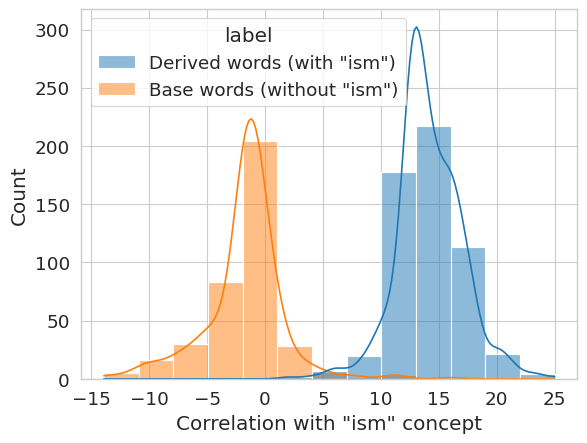

In [7]:
TOKEN = "ism" # ism, ment, ation

ism_token_id = fur.model.tokenizer.encode(TOKEN)[1]

ism_lemmas = df[df["tokens"].list.index(ism_token_id) != -1]["lemma"].str.strip().unique()
ism_negative_lemmas = ism_lemmas.str.replace(TOKEN, "").str.strip().unique()

ism_positive_tokens = df[df["lemma"].isin(ism_lemmas)].drop_duplicates("lemma")["tokens"].to_pandas().values
ism_negative_tokens = df[df["lemma"].isin(ism_negative_lemmas)].drop_duplicates("lemma")["tokens"].to_pandas().values

w_positive = fur.get_token_representations(np.stack(ism_positive_tokens)).mT
w_negative = fur.get_token_representations(np.stack(ism_negative_tokens)).mT

c_positive = Concept(tensor=fur.average_frames(w_positive), synset="derived words")
c_negative = Concept(tensor=fur.average_frames(w_negative), synset="base words")

# the idea of "ism" can be isolated as the average of all words with ism - their counterparts without ism
# only the combined concept is able to gracefully isolate the two groups.
c = c_positive - c_negative
c.tensor.unsqueeze_(0)

x = f"Correlation with \"{TOKEN}\" concept"
y = "label"

df_plot = pd.DataFrame({
    x: torch.cat([w_positive * c, w_negative * c]).flatten().cpu().tolist(),
    y: w_positive.shape[0] * [f"Derived words (with \"{TOKEN}\")"] + w_negative.shape[0] * [f"Base words (without \"{TOKEN}\")"],
})

sns.histplot(df_plot, x=x, hue=y, kde=True)

# df[df["lemma"].isin(negative_lemmas)].drop_duplicates("lemma")